In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# 1 Dataset Construction

In [2]:
# Generate 1D input values
x = torch.linspace(-10, 10, steps=1000)

## Computing Noisy Sinc Function

This code computes the sinc function, defined as `sinc(x) = sin(x)/x`, with a special handling for the case when `x = 0`, where the function is mathematically defined as `1`.

- `torch.where(x == 0, torch.tensor(1.0), torch.sin(x) / x)`: This line computes the sinc function for each element in `x`, replacing any zero in `x` with `1.0` to avoid division by zero.
- `torch.manual_seed(42)`: Sets the random seed for reproducibility of the random noise.
- `noise = 0.1 * torch.randn(x.size())`: Generates Gaussian noise with mean 0 and standard deviation 0.1, matching the shape of `x`.
- `noisy_sinc = sinc + noise`: Adds the generated noise to the computed sinc values to simulate noisy observations of the sinc function.


In [3]:
# Compute sinc function: sinc(x) = sin(x)/x
sinc = torch.where(x == 0, torch.tensor(1.0), torch.sin(x) / x)

torch.manual_seed(42)
# Add Gaussian noise
noise = 0.1 * torch.randn(x.size())
noisy_sinc = sinc + noise

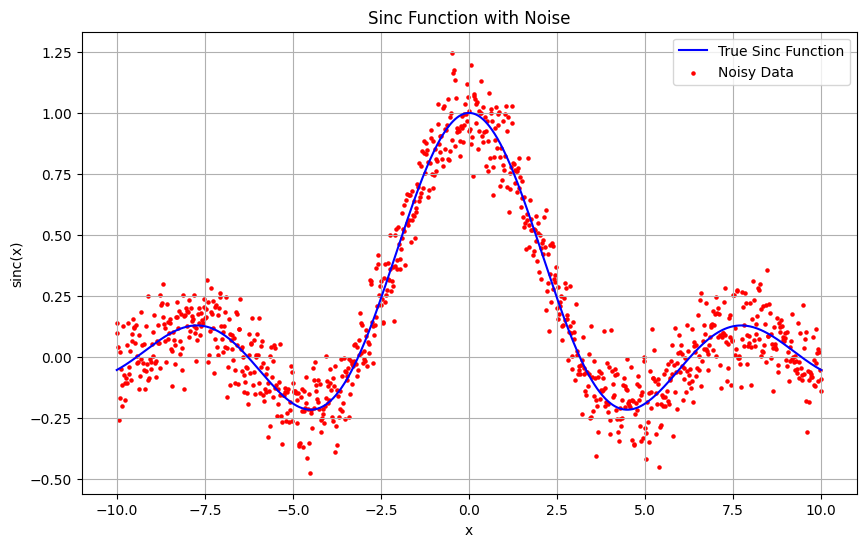

In [4]:
# Set figure size
plt.figure(figsize=(10, 6))

# Plot the true sinc function
plt.plot(x.numpy(), sinc.numpy(), label='True Sinc Function', color='blue')

# Scatter plot of noisy data points
plt.scatter(x.numpy(), noisy_sinc.numpy(), s=5, color='red', label='Noisy Data')

# Axis labels and title
plt.xlabel('x')
plt.ylabel('sinc(x)')
plt.title('Sinc Function with Noise')

# Show legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

# 2 Multilayer Perceptron(MLP) with 2 Hidden Layers

### MLP Model

This code defines a **Multi-Layer Perceptron (MLP)** with two hidden layers using ReLU activation. The model performs a sequence of linear transformations followed by non-linear activations to learn complex patterns in the data.

During the forward pass:
- Input $ x $ is transformed by two hidden layers with weights and biases, each followed by **ReLU** activation:  
  $$ h_1 = \text{ReLU}(W_1 x + b_1), \quad h_2 = \text{ReLU}(W_2 h_1 + b_2) $$
- The final output is computed as:
  $$ \hat{y} = W_3 h_2 + b_3 $$

ReLU introduces non-linearity, allowing the model to approximate complex functions. No activation is applied in the output layer, suitable for **regression tasks**.

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(MLP, self).__init__()
        # First hidden layer
        self.fc1 = nn.Linear(input_size, hidden1_size)
        # Second hidden layer
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        # Output layer
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        # Apply ReLU activation after first layer
        x = F.relu(self.fc1(x))
        # Apply ReLU activation after second layer
        x = F.relu(self.fc2(x))
        # Output layer (no activation for regression)
        x = self.fc3(x)
        return x

### Training Setup

This section sets up the training process for the MLP model to learn the noisy sinc function.

1. **Hyperparameters**:
   - `batch_size = 64`: Number of samples processed in each training step.
   - `learning_rate = 0.001`: Step size used by the optimizer to update model weights.
   - `epochs = 300`: Number of times the entire dataset is passed through the model.

2. **Dataset Preparation**:
   - `TensorDataset`: Combines input `x` and target `noisy_sinc` tensors into a single dataset.
   - `unsqueeze(1)`: Adds a feature dimension to match the expected input shape (i.e., shape `[N, 1]`).
   - `DataLoader`: Provides mini-batches of data with shuffling enabled for better generalization.

3. **Model, Loss, and Optimizer**:
   - `MLP(...)`: Instantiates the multi-layer perceptron with increased capacity (128 and 64 neurons in hidden layers) to better fit the noisy data.
   - `nn.MSELoss()`: Mean Squared Error loss, suitable for regression tasks.
   - `torch.optim.Adam(...)`: Adam optimizer used for efficient gradient-based updates, with L2 regularization (`weight_decay=1e-5`) to help prevent overfitting.

In [6]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 300 

In [7]:
torch.manual_seed(42) # Reproducibility

inputs = x.unsqueeze(1)  # Reshape for model input
targets = noisy_sinc.unsqueeze(1)  # Reshape for model output

# Wrap the data into a TensorDataset and DataLoader
dataset = torch.utils.data.TensorDataset(inputs, targets)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Model, loss, and optimizer
model = MLP(input_size=1, hidden1_size=128, hidden2_size=64, output_size=1)  # Increased neurons
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

### Training Loop

This cell performs the training process of the MLP model using mini-batch gradient descent.

- **Data Preparation**: The input and target tensors are reshaped to match the expected shape `[N, 1]` for the model. These are wrapped into a `TensorDataset` and passed to a `DataLoader` to enable batch training.

- **Model Setup**: The MLP is reinitialized with two hidden layers (128 and 64 neurons). Mean Squared Error (MSE) is used as the loss function, and the Adam optimizer is used with weight decay for regularization.

- **Training Process**:
  - For each of the 300 epochs, the model is trained over all batches.
  - For each batch: predictions are made, loss is computed (mean squared error between predictions and targets), gradients are calculated via backpropagation, and the model parameters are updated using the optimizer.
  - The total loss for each epoch is averaged and stored for visualization or analysis.

Mathematically, this process aims to minimize the loss:
$$ \mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$
where $ y_i $ is the target (noisy sinc value), and $ \hat{y}_i $ is the model's prediction.

In [8]:
# Training loop with mini-batches
epochs = 300  # Increased from 100
train_losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        model.train()
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_inputs.size(0)  # accumulate batch loss weighted by batch size

    epoch_loss /= len(dataloader.dataset)  # average loss per sample
    train_losses.append(epoch_loss)

print(train_losses)

[0.1396166715025902, 0.07168988835811616, 0.04840824243426323, 0.04342699486017227, 0.032321543544530866, 0.026201860085129737, 0.021140709564089775, 0.01768057329952717, 0.017808505043387414, 0.016228842198848726, 0.016861938774585725, 0.01921862941980362, 0.019480282209813595, 0.01751808375120163, 0.014872215241193771, 0.015765530735254288, 0.015152638003230095, 0.016246909230947494, 0.018698889032006262, 0.016202119007706642, 0.016803270816802978, 0.015475885204970837, 0.015654729351401327, 0.015341517381370068, 0.015219320327043533, 0.015014429450035095, 0.016646000862121584, 0.01925603486597538, 0.021664650976657866, 0.019007823884487154, 0.017598839432001114, 0.015475988641381264, 0.01611795900762081, 0.016773984909057616, 0.015013432689011097, 0.01681875266134739, 0.014210188627243043, 0.015950851395726204, 0.017410767756402493, 0.015224272906780243, 0.014185100965201855, 0.01666300795972347, 0.015277965053915977, 0.016107114538550377, 0.014545313969254493, 0.015982428066432477,

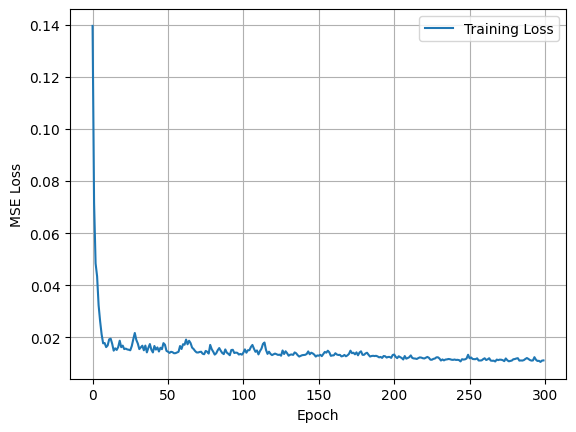

In [9]:
# Plot training loss over epochs
plt.plot(train_losses, label="Training Loss")

# Label x and y axes
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# Show legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### Mesh Grid Creation

This cell creates a 2D mesh grid in the range $[-5, 5]$ for both x and y axes, with a resolution of 1000 points per axis. The steps include:

1. **Defining Range and Resolution**: The domain is set from -5 to 5 for both x and y with 1000 evenly spaced points.
2. **Creating 1D Arrays**: `np.linspace` generates 1D arrays of points for x and y.
3. **Creating a 2D Grid**: `np.meshgrid` forms two 2D arrays `X` and `Y`, where each point in the grid corresponds to a coordinate $(x, y)$.
4. **Conversion to PyTorch**: The NumPy arrays are converted to PyTorch tensors (`X_tensor`, `Y_tensor`) to be used in subsequent tensor-based computations.

The resulting tensors represent a coordinate grid over a 2D space and are typically used for visualizing functions or evaluating models over a surface.

In [10]:
x_min, x_max = -5, 5
y_min, y_max = -5, 5
resolution = 1000  # Number of points in each dimension

# Step 2: Generate 1D arrays using numpy.linspace()
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)

# Step 3: Create a 2D mesh grid using numpy.meshgrid()
X, Y = np.meshgrid(x, y)

# Step 4: Convert the numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Now X_tensor and Y_tensor are PyTorch tensors representing the mesh grid
print(f"Shape of X_tensor: {X_tensor.shape}")
print(f"Shape of Y_tensor: {Y_tensor.shape}")

Shape of X_tensor: torch.Size([1000, 1000])
Shape of Y_tensor: torch.Size([1000, 1000])


In [11]:
model.eval()

# Create prediction grid matching original data range
x_grid = torch.linspace(-10, 10, 1000).reshape(-1, 1)

# Compute predictions without tracking gradients
with torch.no_grad():
    y_pred = model(x_grid)

# Reshape predictions for visualization
predictions = y_pred.numpy().reshape(-1)

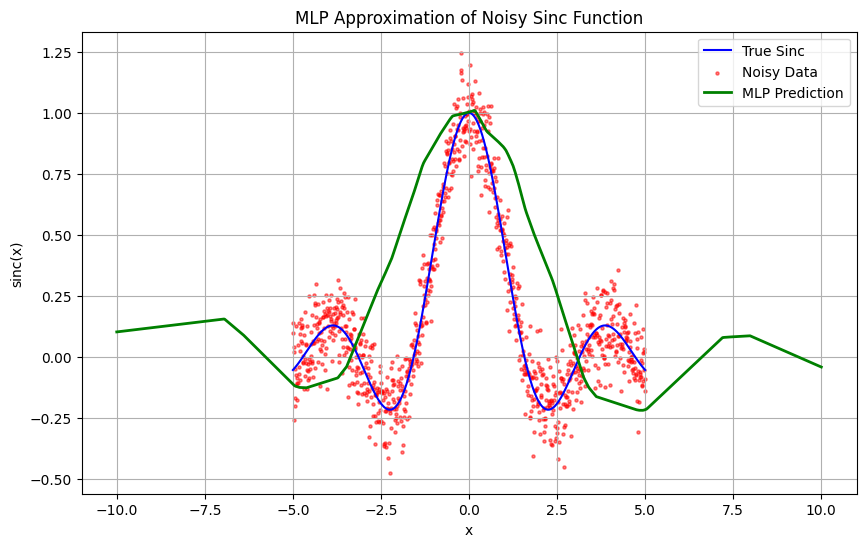

In [12]:
plt.figure(figsize=(10, 6))

# Plot the true sinc function in blue
plt.plot(x, sinc.numpy(), label='True Sinc', color='blue')

# Scatter plot of noisy data points in red with some transparency
plt.scatter(x, noisy_sinc.numpy(), s=5, color='red', alpha=0.5, label='Noisy Data')

# Plot the MLP model's predictions in green with a thicker line
plt.plot(x_grid.numpy(), predictions, color='green', linewidth=2, label='MLP Prediction')

# Set labels for x and y axes
plt.xlabel('x')
plt.ylabel('sinc(x)')

# Set the plot title
plt.title('MLP Approximation of Noisy Sinc Function')

# Add a legend to label the curves
plt.legend()

# Enable grid lines for better readability
plt.grid(True)

# Display the plot
plt.show()

# 3 CNN with Pytorch

### `RockPaperScissorsDataset` Class

This class defines a custom dataset for the Rock-Paper-Scissors image classification task, using PyTorch's `Dataset` class. It enables easy loading of images and labels for model training.

1. **Initialization (`__init__`)**:
   - `root_dir`: The root directory where images are stored, organized into subfolders (`rock`, `paper`, `scissors`).
   - `transform`: Optional transformations (e.g., resizing, normalization) to apply to each image.
   - **Image Collection**: The dataset iterates through each class folder, collects image paths (`.png` files), and assigns corresponding labels (0 for rock, 1 for paper, 2 for scissors).

2. **Length (`__len__`)**:
   - Returns the total number of images in the dataset.

3. **Item Retrieval (`__getitem__`)**:
   - Given an index `idx`, it loads the corresponding image, applies any specified transformations, and returns the image along with its class label.

This custom dataset allows the model to easily access images and their labels for training and testing.

In [13]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class RockPaperScissorsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Initialize dataset with root directory and optional transforms
        self.root_dir = root_dir
        self.transform = transform

        # Define the class labels (rock, paper, scissors)
        self.classes = ['rock', 'paper', 'scissors']
        
        # Initialize lists for storing image paths and corresponding labels
        self.image_paths = []
        self.labels = []

        # Loop through each class and collect image paths and labels
        for idx, label in enumerate(self.classes):
            class_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(class_dir):
                # Only consider .png images
                if img_name.endswith('.png'):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(idx)

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Retrieve image path and label for a given index
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Open the image and convert to RGB
        image = Image.open(image_path).convert('RGB')

        # Apply transformations (if any) to the image
        if self.transform:
            image = self.transform(image)

        # Return the image and its corresponding label
        return image, label

### Dataset Transformation and Train-Test Split

This cell prepares the Rock-Paper-Scissors dataset for training and testing, applying image transformations and splitting the dataset into training and test sets.

1. **Transformations**:
   - `transforms.Compose`: A sequence of transformations applied to each image:
     - `Resize((200, 300))`: Resizes each image to a fixed size of 200x300 pixels to match the model's expected input size.
     - `ToTensor()`: Converts the image to a PyTorch tensor (from a PIL image).
     - `Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])`: Normalizes the image to the range \([-1, 1]\), centered around 0 with standard deviation 0.5.

2. **Dataset Creation**:
   - The `RockPaperScissorsDataset` is initialized using the specified root directory (`'rps-cv-images'`) and the defined transformations.

3. **Train-Test Split**:
   - `train_size`: 80% of the dataset is assigned to the training set.
   - `test_size`: The remaining 20% is assigned to the test set.
   - `torch.Generator().manual_seed(42)`: Sets a random seed for reproducibility in the dataset split.
   - `random_split`: Splits the dataset into training and test sets according to the specified sizes.

This prepares the dataset for model training with appropriate preprocessing and ensures that the train-test split is reproducible.


In [14]:
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.Resize((200, 300)),  # Resize to match original size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

dataset = RockPaperScissorsDataset(root_dir='rps-cv-images', transform=transform)

# Train-test split (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

In [15]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        # Initialize the simple convolutional network
        super(SimpleConvNet, self).__init__()
        
        # Define the first convolutional layer (3 input channels, 1 output channel, 3x3 kernel, stride 1, padding 1)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Pass input through the convolutional layer
        return self.conv1(x)

In [16]:
# Initialize the SimpleConvNet model
model = SimpleConvNet()

# Set the random seed for reproducibility
torch.manual_seed(42)

# Create a dummy input tensor with shape [batch_size=1, channels=3, height=200, width=300]
dummy_input = torch.randn(1, 3, 200, 300)

# Pass the dummy input through the model to get the output
output = model(dummy_input)
print(output.shape) # Expected shape is [1, 1, 200, 300] due to stride=1, padding=1, kernel_size=3

torch.Size([1, 1, 200, 300])


### Depthwise Convolution with Blur Kernel

This code applies a depthwise convolution to an image using a simple blur kernel. The steps are as follows:

1. **Blur Kernel Creation**:
   - A 3x3 blur kernel is created with equal weights for each element and normalized by dividing by 9.0, making it a simple average filter.
   
2. **Depthwise Convolution Setup**:
   - The kernel is reshaped and replicated for each of the 3 input channels (RGB) to make it depthwise. This means each channel will be convolved independently with its corresponding kernel.
   - A depthwise convolution layer is defined using `nn.Conv2d` with 3 input channels, 3 output channels, and a kernel size of 3x3, with `groups=3` to apply separate convolutions for each channel.

3. **Image Loading**:
   - The code loads an image from the "rock" class folder, converts it into a tensor, and adds a batch dimension (making it `[1, 3, H, W]`).

4. **Convolution Application**:
   - The image tensor is passed through the convolution layer. The `torch.no_grad()` context is used to prevent the tracking of gradients during this operation, as no backpropagation is needed.

5. **Display the Images**:
   - The original and convolved images are displayed using `show_tensor()`, which converts the tensor back to a NumPy array and uses `matplotlib` for visualization.

This process demonstrates a simple image blurring operation using depthwise convolution, where each channel (RGB) is processed independently with the same kernel.

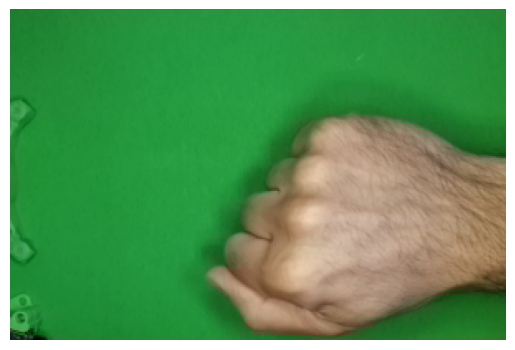

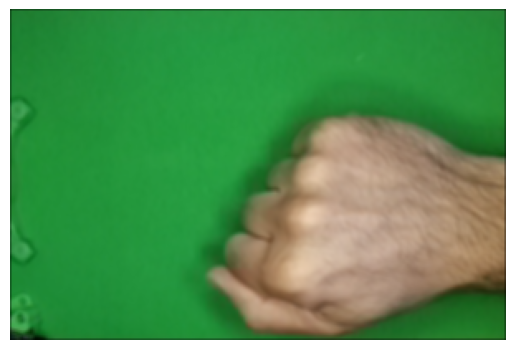

In [17]:
from torchvision.transforms import ToTensor
to_tensor = ToTensor()

blur_kernel = torch.tensor([[1, 1, 1],
                            [1, 1, 1],
                            [1, 1, 1]], dtype=torch.float32) / 9.0

# Make it depthwise: (3 output, 1 input per group, 3x3 kernel)
kernel = blur_kernel.view(1, 1, 3, 3).repeat(3, 1, 1, 1)

# Define depthwise conv layer
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1, groups=3, bias=False)
conv.weight.data = kernel

# Load an image dynamically
rock_path = "rps-cv-images/rock"
img_name = os.listdir(rock_path)[0]
img_path = os.path.join(rock_path, img_name)

img = Image.open(img_path)
img_tensor = to_tensor(img).unsqueeze(0)  # [1, 3, H, W]

# Apply convolution
with torch.no_grad():
    out = conv(img_tensor)

# Show images
def show_tensor(t):
    npimg = t.squeeze().permute(1, 2, 0).numpy()
    plt.imshow(np.clip(npimg, 0, 1))
    plt.axis('off')
    plt.show()

show_tensor(img_tensor[0])
show_tensor(out[0])

### Applying Custom Kernels to Images

This code applies two custom convolutional kernels (sharpening and edge detection) to an image and visualizes the results.

1. **Custom Kernel Function**:
   - `apply_custom_kernel(kernel_matrix, name="")`: A function that takes a kernel matrix, reshapes it to match the depthwise convolution format, and applies it to the input image.
   - The kernel is replicated for each RGB channel, and a depthwise convolution layer is created using `nn.Conv2d` with `groups=3` to independently convolve each channel.
   - The convolution is performed inside a `torch.no_grad()` context to avoid tracking gradients.
   - The resulting output is displayed using the `show_tensor()` function, and the output shape is printed.

2. **Sharpening Kernel**:
   - A kernel designed to sharpen the image. The center value is 5, and the surrounding values are negative, which enhances edges by emphasizing differences.

3. **Edge Detection Kernel**:
   - A kernel designed for detecting edges in an image. The center value is 8, and the surrounding values are negative, emphasizing areas of high intensity change (edges).

4. **Visualization**:
   - The original image is shown first, followed by the results of applying the sharpen and edge detection kernels. Each transformed image is displayed, and the shape of the output tensor is printed.

This process demonstrates how different convolutional filters (kernels) can modify an image to highlight specific features, such as sharpness or edges.

Original Image:


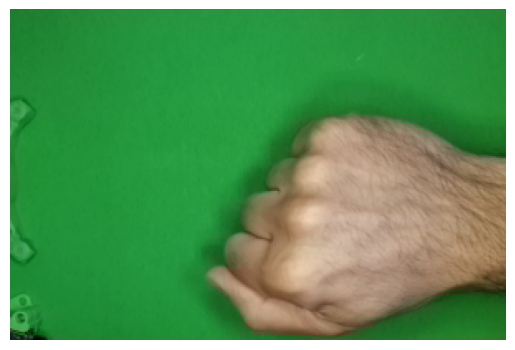

Sharpen Output Shape: torch.Size([1, 3, 200, 300])


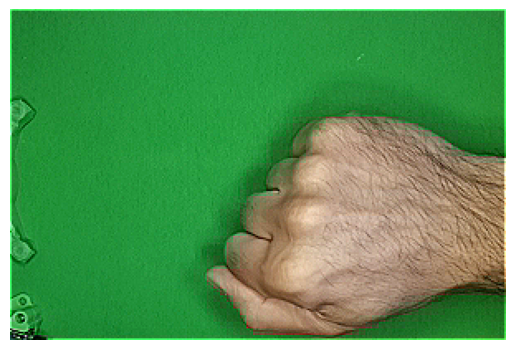

Edge Detection Output Shape: torch.Size([1, 3, 200, 300])


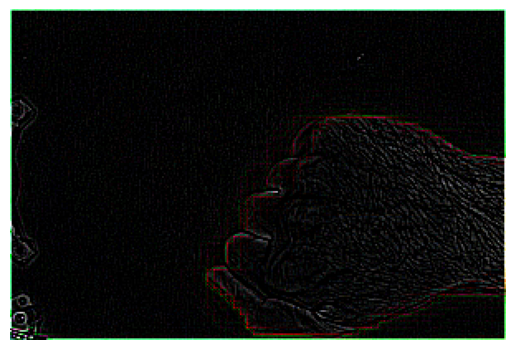

In [18]:
def apply_custom_kernel(kernel_matrix, name=""):
    kernel = kernel_matrix.view(1, 1, 3, 3).repeat(3, 1, 1, 1)
    conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1, groups=3, bias=False)
    conv.weight.data = kernel

    with torch.no_grad():
        out = conv(img_tensor)
    
    print(f"{name} Output Shape:", out.shape)
    show_tensor(out[0])

sharpen_kernel = torch.tensor([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]], dtype=torch.float32)

edge_kernel = torch.tensor([[-1, -1, -1],
                            [-1,  8, -1],
                            [-1, -1, -1]], dtype=torch.float32)

# Apply and visualize
print("Original Image:")
show_tensor(img_tensor[0])

apply_custom_kernel(sharpen_kernel, name="Sharpen")
apply_custom_kernel(edge_kernel, name="Edge Detection")

With kernel_size=5, stride=2, padding=2:
Output shape: torch.Size([1, 3, 100, 150])


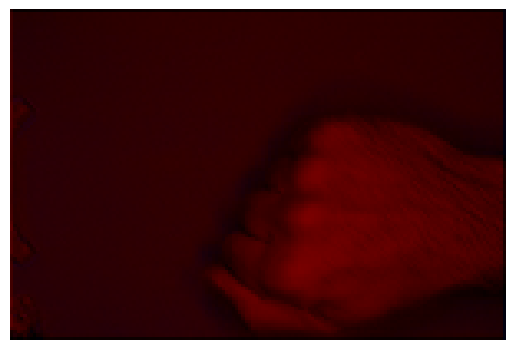

In [19]:
# Define a convolutional layer with different kernel size, stride, and padding values
conv_varied = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=2, padding=2)

# Apply the convolutional layer to the image tensor without tracking gradients
with torch.no_grad():
    out_varied = conv_varied(img_tensor)

# Print the output shape and display the resulting image after convolution
print("With kernel_size=5, stride=2, padding=2:")
print("Output shape:", out_varied.shape)
show_tensor(out_varied[0])

### CNN with Convolution and Max Pooling Layer

This code defines a simple convolutional neural network (CNN) model with a convolutional layer followed by a max pooling layer.

1. **Convolutional Layer (`nn.Conv2d`)**:
   - The model begins with a convolutional layer that takes an input with 3 channels (e.g., RGB image), applies a 3x3 kernel with padding of 1, and outputs 3 channels.
   - Padding of 1 ensures that the spatial dimensions of the input are preserved after the convolution operation.

2. **Max Pooling Layer (`nn.MaxPool2d`)**:
   - After the convolution, the output is passed through a max pooling layer with a 2x2 kernel and a stride of 2.
   - Max pooling reduces the spatial dimensions by half (downsampling) and retains the most significant feature in each region.

3. **Forward Pass**:
   - The forward method first applies the convolution and then the max pooling operation in sequence, returning the downsampled feature map.

This simple architecture is commonly used in CNNs to extract features and progressively reduce the spatial dimensions of the input data.

In [20]:
class CNNWithMaxPool(nn.Module):
    def __init__(self):
        # Initialize convolutional layer with 3 input channels, 3 output channels, 3x3 kernel, and padding of 1
        super(CNNWithMaxPool, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        
        # Initialize max pooling layer with 2x2 kernel and stride of 2 (downsampling)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Apply convolutional layer followed by max pooling
        x = self.conv(x)
        x = self.pool(x)
        return x

Before pooling: torch.Size([1, 3, 200, 300])


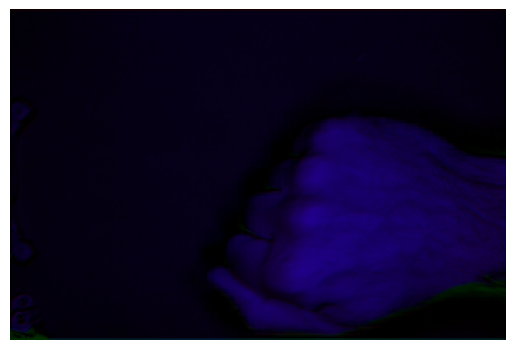

After pooling: torch.Size([1, 3, 100, 150])


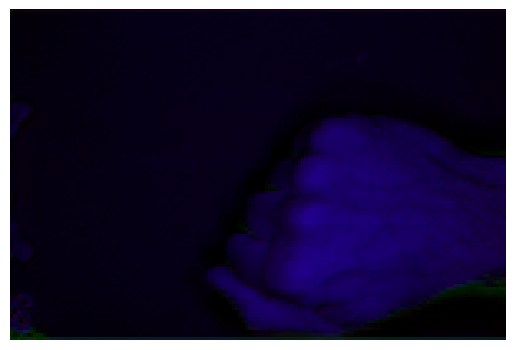

In [21]:
# Set the random seed for reproducibility
torch.manual_seed(18)

# Initialize the CNN model
model = CNNWithMaxPool()

# Apply the convolutional layer to the image tensor (before pooling)
with torch.no_grad():
    conv_output = model.conv(img_tensor)  # Convolution output (before pooling)
    
    # Apply max pooling to the convolution output (after pooling)
    pooled_output = model.pool(conv_output)

print("Before pooling:", conv_output.shape)
show_tensor(conv_output[0])  # Display the image after convolution

print("After pooling:", pooled_output.shape)
show_tensor(pooled_output[0])  # Display the image after max pooling

In [22]:
# Define the Global Average Pooling (GAP) layer
gap = nn.AdaptiveAvgPool2d((1, 1))

# Apply the GAP layer to the convolution output
with torch.no_grad():
    gap_output = gap(conv_output)

# Print the output shape after GAP and display the values (squeezed to remove extra dimensions)
print("After Global Average Pooling:", gap_output.shape)
print("Values:\n", gap_output.squeeze())  # Remove the singleton dimensions for better readability

After Global Average Pooling: torch.Size([1, 3, 1, 1])
Values:
 tensor([ 0.0324, -0.1198,  0.1290])


### CompleteCNN Model

This model is a Convolutional Neural Network (CNN) designed to classify images into three categories: rock, paper, and scissors. It consists of the following components:

1. **Convolutional Layers**:
   - Three convolutional layers, each followed by ReLU activations and MaxPooling. The convolutional layers extract spatial features from the input image.
   - After each convolution, the image dimensions are reduced using MaxPooling, which helps in capturing high-level features while reducing computational complexity.

2. **Global Average Pooling (GAP)**:
   - GAP reduces the spatial dimensions of the feature map to a single value per channel (i.e., converts the feature map to a `[B, 64, 1, 1]` shape), making the network invariant to the spatial resolution of the input.

3. **Fully Connected Classifier**:
   - A Multi-Layer Perceptron (MLP) with one hidden layer that flattens the feature map and outputs a prediction for each class (rock, paper, scissors).
   
The network combines convolutional feature extraction, global pooling for spatial invariance, and fully connected layers for classification.

In [23]:
class CompleteCNN(nn.Module):
    def __init__(self):
        super(CompleteCNN, self).__init__()

        # 3 convolutional layers with ReLU and MaxPooling
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Conv -> [B, 16, 200, 300]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Pool -> [B, 16, 100, 150]

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Conv -> [B, 32, 100, 150]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Pool -> [B, 32, 50, 75]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv -> [B, 64, 50, 75]
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Pool -> [B, 64, 25, 37]
        )

        # Global Average Pooling (GAP)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # MLP classifier with one hidden layer
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten to [B, 64]
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # 3 classes: rock, paper, scissors
        )

    def forward(self, x):
        print("Input:", x.shape)  # Expecting [B, 3, 200, 300]

        x = self.features[0](x)  # Conv1
        print("After Conv1:", x.shape)
        x = self.features[1](x)  # ReLU
        x = self.features[2](x)  # MaxPool
        print("After Pool1:", x.shape)

        x = self.features[3](x)  # Conv2
        print("After Conv2:", x.shape)
        x = self.features[4](x)  # ReLU
        x = self.features[5](x)  # MaxPool
        print("After Pool2:", x.shape)

        x = self.features[6](x)  # Conv3
        print("After Conv3:", x.shape)
        x = self.features[7](x)  # ReLU
        x = self.features[8](x)  # MaxPool
        print("After Pool3:", x.shape)

        x = self.gap(x)
        print("After GAP:", x.shape)  # Should be [B, 64, 1, 1]

        x = self.classifier[0](x)
        print("After Flatten:", x.shape)  # Should be [B, 64]
        x = self.classifier[1](x)
        print("After FC1 (Linear 64 -> 32):", x.shape)
        x = self.classifier[2](x)
        x = self.classifier[3](x)
        print("After FC2 (Linear 32 -> 3):", x.shape)

        return x


In [24]:
# Set random seed for reproducibility
seed = 106
torch.manual_seed(seed)

# Initialize the model
model = CompleteCNN()

# Create a dummy input: 1 RGB image of size 200x300
dummy_input = torch.randn(1, 3, 200, 300)
output = model(dummy_input) # Perform a forward pass through the model

Input: torch.Size([1, 3, 200, 300])
After Conv1: torch.Size([1, 16, 200, 300])
After Pool1: torch.Size([1, 16, 100, 150])
After Conv2: torch.Size([1, 32, 100, 150])
After Pool2: torch.Size([1, 32, 50, 75])
After Conv3: torch.Size([1, 64, 50, 75])
After Pool3: torch.Size([1, 64, 25, 37])
After GAP: torch.Size([1, 64, 1, 1])
After Flatten: torch.Size([1, 64])
After FC1 (Linear 64 -> 32): torch.Size([1, 32])
After FC2 (Linear 32 -> 3): torch.Size([1, 3])


In [25]:
# Hyperparameters
batch_size = 32
learning_rate = 0.05
num_epochs = 10

# Dataloaders for training and testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = CompleteCNN()

# Define the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the chosen device (GPU or CPU)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)  # Stochastic Gradient Descent optimizer

### Training and Evaluation Loop

This section of the code defines the training and evaluation process for the CNN model. Here's a breakdown of the process:

1. **Evaluation Function:**
   - The `evaluate` function computes the accuracy on a given dataset (train/test) by performing a forward pass, comparing the predicted labels to the ground truth, and calculating the ratio of correct predictions.

2. **Training Loop:**
   - For each epoch, the model is set to training mode with `model.train()`.
   - The loop iterates over the training batches, where:
     - The gradients are zeroed using `optimizer.zero_grad()`.
     - A forward pass is performed to calculate the output of the model.
     - The loss is computed and backpropagated with `loss.backward()`.
     - The model weights are updated with `optimizer.step()`.
   - After each batch, the loss is accumulated and the number of correct predictions is tracked.

3. **Accuracy Calculation:**
   - At the end of each epoch, the training accuracy (`train_acc`) is calculated based on the correct predictions and total samples.
   - The test accuracy (`test_acc`) is calculated using the `evaluate` function.

4. **Results:**
   - After every epoch, the training and test accuracies, as well as the average loss for the epoch, are printed.
   - These accuracies are stored in `train_acc_list` and `test_acc_list` for later analysis, such as plotting performance curves.

This loop continues for the specified number of epochs (`num_epochs`).

In [26]:
# Lists to store training and test accuracies for each epoch
train_acc_list = []
test_acc_list = []

# Function to evaluate accuracy on a given data loader (train/test)
def evaluate(loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Total samples processed
    
    return correct / total  # Return accuracy

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0
    correct = 0
    total = 0

    # Loop over batches in the training set
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Zero out the gradients
        outputs = model(imgs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Total samples processed

    # Calculate training and test accuracy for the current epoch
    train_acc = correct / total
    test_acc = evaluate(test_loader, device)
    
    # Store the accuracies
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

Input: torch.Size([32, 3, 200, 300])
After Conv1: torch.Size([32, 16, 200, 300])
After Pool1: torch.Size([32, 16, 100, 150])
After Conv2: torch.Size([32, 32, 100, 150])
After Pool2: torch.Size([32, 32, 50, 75])
After Conv3: torch.Size([32, 64, 50, 75])
After Pool3: torch.Size([32, 64, 25, 37])
After GAP: torch.Size([32, 64, 1, 1])
After Flatten: torch.Size([32, 64])
After FC1 (Linear 64 -> 32): torch.Size([32, 32])
After FC2 (Linear 32 -> 3): torch.Size([32, 3])
Input: torch.Size([32, 3, 200, 300])
After Conv1: torch.Size([32, 16, 200, 300])
After Pool1: torch.Size([32, 16, 100, 150])
After Conv2: torch.Size([32, 32, 100, 150])
After Pool2: torch.Size([32, 32, 50, 75])
After Conv3: torch.Size([32, 64, 50, 75])
After Pool3: torch.Size([32, 64, 25, 37])
After GAP: torch.Size([32, 64, 1, 1])
After Flatten: torch.Size([32, 64])
After FC1 (Linear 64 -> 32): torch.Size([32, 32])
After FC2 (Linear 32 -> 3): torch.Size([32, 3])
Input: torch.Size([32, 3, 200, 300])
After Conv1: torch.Size([32, 

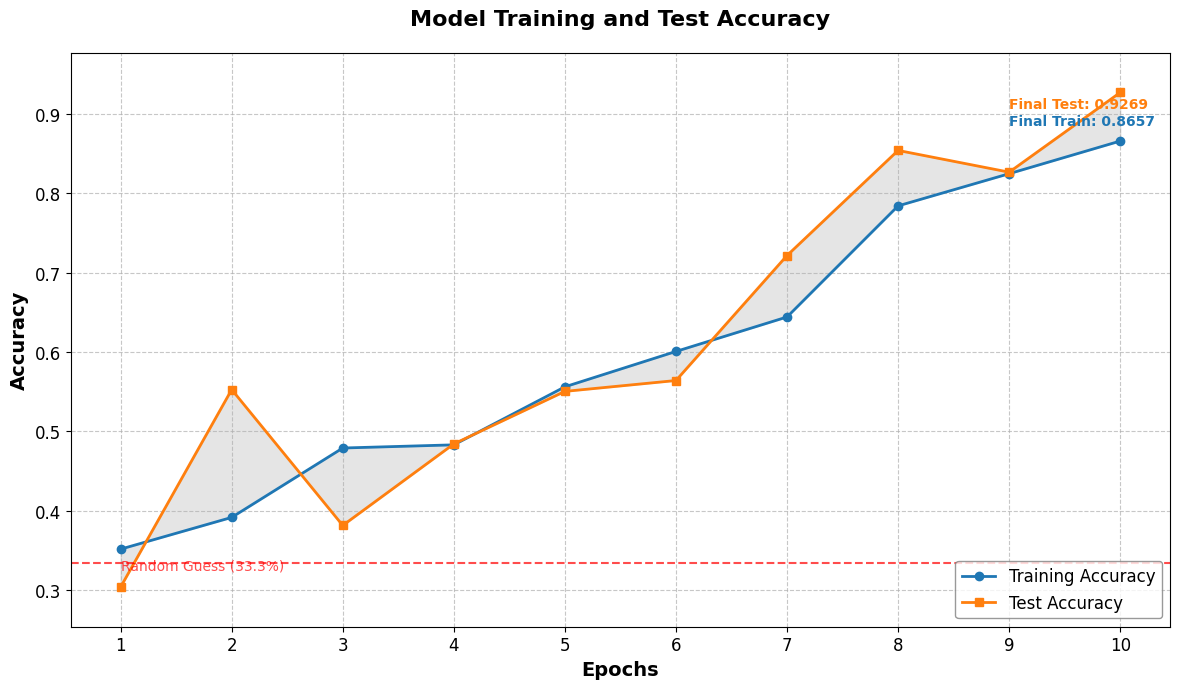

In [28]:
from matplotlib.ticker import MaxNLocator

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)

# Create x-axis values (epochs)
epochs = np.arange(1, len(train_acc_list) + 1)

# Plot the data
ax.plot(epochs, train_acc_list, marker='o', linestyle='-', linewidth=2, 
        markersize=6, label='Training Accuracy', color='#1f77b4')
ax.plot(epochs, test_acc_list, marker='s', linestyle='-', linewidth=2, 
        markersize=6, label='Test Accuracy', color='#ff7f0e')

# Fill the area between train and test accuracy
ax.fill_between(epochs, train_acc_list, test_acc_list, alpha=0.2, color='gray')

# Customize the plot
ax.set_xlabel('Epochs', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Model Training and Test Accuracy', fontsize=16, fontweight='bold', pad=20)

# Set x-axis to show integer values
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)

# Add legend
ax.legend(loc='lower right', fontsize=12, frameon=True, framealpha=0.8, edgecolor='gray')

# Set y-axis limits with some padding
ax.set_ylim(min(min(train_acc_list), min(test_acc_list)) - 0.05, 
            max(max(train_acc_list), max(test_acc_list)) + 0.05)

# Add annotations for final accuracies
ax.annotate(f'Final Train: {train_acc_list[-1]:.4f}', 
            xy=(len(train_acc_list), train_acc_list[-1]),
            xytext=(len(train_acc_list)-1, train_acc_list[-1]+0.02),
            fontsize=10, fontweight='bold', color='#1f77b4')

ax.annotate(f'Final Test: {test_acc_list[-1]:.4f}', 
            xy=(len(test_acc_list), test_acc_list[-1]),
            xytext=(len(test_acc_list)-1, test_acc_list[-1]-0.02),
            fontsize=10, fontweight='bold', color='#ff7f0e')

# Add a horizontal line for random guessing (assuming 3 classes)
ax.axhline(y=1/3, color='red', linestyle='--', alpha=0.7)
ax.text(1, 1/3 -  0.008, 'Random Guess (33.3%)', fontsize=10, color='red', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()
